<a href="https://colab.research.google.com/github/marissa-graham/deep_learning/blob/master/Lab_5_(Style_Transfer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Grading standards

* 35% Correct extraction of statistics
* 45% Correct construction of loss function in a loss class
* 10% Correct initialization and optimization of image variable in a dataset class
* 10% Awesome looking final image

## Installs and imports

In [0]:
!pip install --no-cache-dir -I pillow # This line must be FIRST
!pip3 install torch torchvision tqdm

    100% |████████████████████████████████| 2.0MB 10.7MB/s 
    100% |████████████████████████████████| 519.5MB 20kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5922c000 @  0x7f5b280192a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 19.6MB/s 


In [0]:
#from __future__ import print_function # WHY DO WE WANT THAT?

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim

from torchvision import transforms, models
import copy # For a deepcopy

import numpy as np
from matplotlib import pyplot as plt
import seaborn

import PIL.Image as Image

# Gotta do this crap again apparently
def register_extension(id, extension):
    Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension

def register_extensions(id, extensions):
    for extension in extensions:
        register_extension(id, extension)
Image.register_extensions = register_extensions


import io
import gc
from google.colab import files
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg',tb_offset = 1)
 

assert torch.cuda.is_available()

## Image uploading and helpers

In [0]:
load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])
unload_image = transforms.ToPILImage()
plt.ion()
 

print('Upload Content Image')
file_dict = files.upload()
content_image = Image.open(io.BytesIO(file_dict[next(iter(file_dict))]))
content_image = load_and_normalize(np.array(content_image)).unsqueeze(0)
 
print('\nUpload Style Image')
file_dict = files.upload()
style_image = Image.open(io.BytesIO(file_dict[next(iter(file_dict))]))
style_image = load_and_normalize(np.array(style_image)).unsqueeze(0)


Upload Content Image


Saving content_image.png to content_image (1).png

Upload Style Image


Saving style_image.png to style_image.png


## VGG network stuff

In [0]:
class VGGIntermediate(nn.Module):
    """
    Adds a post-hook to the VGG model so that after every layer it writes the
    output of the layers we care about to a dictionary. That is, we create a 
    dictionary of the desired output activation layers.
    
    Names of non-reLU layers
    ------------------------
    Level 1: "conv1_1", "conv1_2", "maxpool1"
    Level 2: "conv2_1", "conv2_2", "maxpool2"
    Level 3: "conv3_1", "conv3_2", "conv3_3", "maxpool3"
    Level 4: "conv4_1", "conv4_2", "conv4_3", "maxpool4"
    Level 5: "conv5_1", "conv5_2", "conv5_3", "maxpool5"
    """
    def __init__(self, req=[]):
        
        super(VGGIntermediate, self).__init__()

        self.intermediates = {}
        self.vgg = models.vgg16(pretrained=True).features.eval()
        
        for i, m in enumerate(self.vgg.children()):
            
            if isinstance(m, nn.ReLU):
                m.inplace = False
                
            if isinstance(m, nn.MaxPool2d):
                m = nn.AvgPool2d(m.kernel_size, m.stride, m.padding, m.ceil_mode)
                
            if i in req:
                def curry(i):
                    def hook(module, input, output):
                        self.intermediates[i] = output
                    return hook
                m.register_forward_hook(curry(i))
        
    def forward(self, x):
        self.vgg(x) 
        
        #features = dict()
        #for key in self.intermediates:
        #    features[key] = self.intermediates[key].clone()
        #return features
        return self.intermediates

## Loss classes and such

In [0]:

def Gram_matrix(v):
    
    F_l = v.squeeze(0).view(v.size()[1], -1)
    num_entries = float(np.prod(list(F_l.size())))
    
    return torch.matmul(F_l, F_l.t()).div(num_entries)
"""
# Garrett's Gram matrix that we were testing to see if that was the problem
def Gram_matrix(input):
    a, b, c, d = input.size() 
    features = input.view(a * b, c * d)#looks like this is better reshaping
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d).cuda()
"""
class ContentLoss(nn.Module):
    """
    Calculate the loss as described in Gatys et. al.
    """
    
    def __init__(self, true_content):
        
        super(ContentLoss, self).__init__()
        a, b, c, d = true_content.size()
        self.true_content = true_content.detach().reshape(a*b,c*d)
        
        
    def forward(self, x):
        """
        Input should be the model at the desired layer.
        """
        a, b, c, d = x.size()
        return F.mse_loss(x.reshape(a*b,c*d), self.true_content)
    
class StyleLoss(nn.Module):
    
    def __init__(self, true_styles, style_layers):
        """
        Style weights will just be "take the average across given layers".
        """
        super(StyleLoss, self).__init__()
        
        self.true_styles = dict()
        for key in style_layers:
            self.true_styles[key] = Gram_matrix(true_styles[key]).detach()
        self.style_layers = style_layers
    
    def forward(self, x):
        
        loss = 0
        for l in self.style_layers:
            loss += 0.2*F.mse_loss(Gram_matrix(x[l]), self.true_styles[l])
        return loss
    
class Normalization(nn.Module):
    
    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1,1,1).cuda()
        self.std = torch.tensor(std).view(-1,1,1).cuda()
    
    def forward(self, img):
        return (img - self.mean) / self.std
    
def show_image(tensor_version, title=None):
    
    image = tensor_version.cpu().clone() # copy for safety (needs .cpu())?
    model = nn.Sigmoid()
    image = model(image) 
    image = image.squeeze(0) # we don't actually have a batch dimension
    image = image - torch.min(image)
    image = image/torch.max(image)
    image = unload_image(image.data.clamp_(0,1))
    #image = unload_image(image)
    
    plt.imshow(image)
    plt.grid(None)
    plt.yticks([])
    plt.xticks([])
    
    if title:
        plt.title(title)
    plt.show()

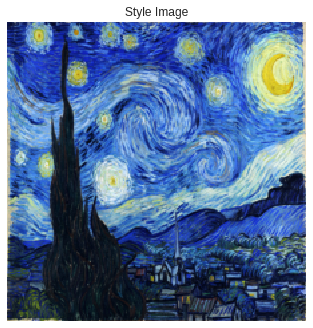

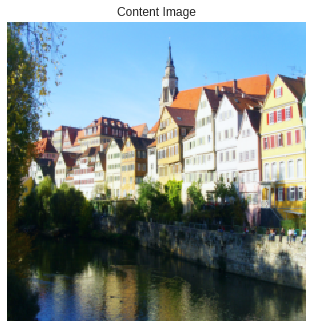

Step 0 losses:	Content 0.0006   Style 0.0090772   Total 90.7728


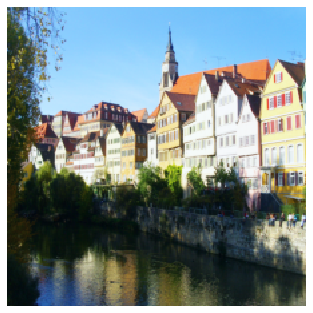

Step 250 losses:	Content 7.0278   Style 0.0006249   Total 13.2767
Step 500 losses:	Content 7.0261   Style 0.0005787   Total 12.8132
Step 750 losses:	Content 6.7481   Style 0.0005628   Total 12.3761
Step 1000 losses:	Content 7.7709   Style 0.0006016   Total 13.7869
Step 1250 losses:	Content 8.0941   Style 0.0006933   Total 15.0272
Step 1500 losses:	Content 6.6529   Style 0.0005084   Total 11.7369
Step 1750 losses:	Content 6.2732   Style 0.0005086   Total 11.3587
Step 2000 losses:	Content 7.3141   Style 0.0005792   Total 13.1063
Step 2250 losses:	Content 6.5276   Style 0.0005523   Total 12.0504
Step 2500 losses:	Content 5.9915   Style 0.0005352   Total 11.3437


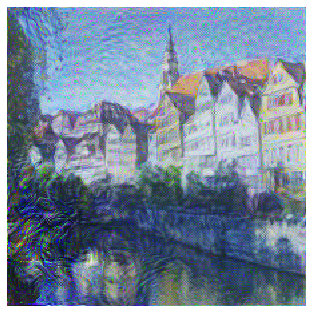

Step 2750 losses:	Content 6.1133   Style 0.0005471   Total 11.584
Step 3000 losses:	Content 6.3618   Style 0.0005275   Total 11.6371
Step 3250 losses:	Content 6.9621   Style 0.0005649   Total 12.6115
Step 3500 losses:	Content 6.1301   Style 0.0005043   Total 11.1729
Step 3750 losses:	Content 6.4003   Style 0.0005329   Total 11.7291
Step 4000 losses:	Content 5.9001   Style 0.0005063   Total 10.9633
Step 4250 losses:	Content 7.2586   Style 0.0006295   Total 13.5535
Step 4500 losses:	Content 5.858   Style 0.000523   Total 11.0878
Step 4750 losses:	Content 9.4007   Style 0.0006398   Total 15.7989
Step 5000 losses:	Content 6.1287   Style 0.0005015   Total 11.1436


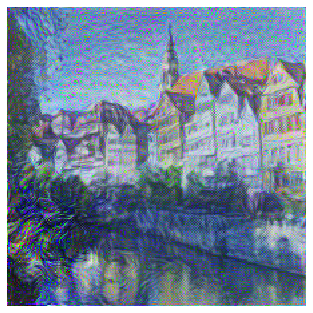

KeyboardInterrupt: ignored

In [0]:
vgg_names = [
"conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", 
"conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2",
"conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3",
"conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4",
"conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"
]
name_inds = {vgg_names[i]:i for i in range(len(vgg_names))}

content_layers = ["conv4_2"]
content_inds = [name_inds[l] for l in content_layers]
style_layers = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]
style_inds = [name_inds[l] for l in style_layers]
training_inds = content_inds + style_inds

style_vgg = VGGIntermediate(req=style_inds).cuda()
content_vgg = VGGIntermediate(req=content_inds).cuda()
training_vgg = VGGIntermediate(req=training_inds).cuda()

# Get the style and content images
style_image = Image.open("style_image.png")
style_image = load_and_normalize(np.array(style_image)).unsqueeze(0)

content_image = Image.open("content_image.png")
content_image = load_and_normalize(np.array(content_image)).unsqueeze(0)

style_layerdict = style_vgg(style_image.cuda())
content_layerdict = content_vgg(content_image.cuda())

style_loss = StyleLoss(style_layerdict, style_layers=style_inds)
content_loss = ContentLoss(content_layerdict[content_inds[0]])

# Initialize a Gaussian white noise image of correct size
#x = torch.randn_like(content_image).cuda()
#x.data.clamp_(0,1)cop
x = copy.deepcopy(content_image.cuda()) + 0.001*torch.randn_like(content_image).cuda()

show_image(style_image, "Style Image")
show_image(content_image, "Content Image")
#show_image(x, "Initial random image")
    
beta = 1e4 # Style weighting
alpha = 1 # Content weighting

c_layer = 19

optimizer = optim.Adam([x.requires_grad_()], lr=0.1)
normalizer = Normalization()
model = nn.Sigmoid()
    
num_steps = 10000
losses = []

for epoch in range(num_steps):
    
    gc.collect()
    optimizer.zero_grad()
    
    #vgg_x = training_vgg(normalizer(x).cuda())
    vgg_x = training_vgg(x.cuda())
    x_style_layers = {i:vgg_x[i] for i in style_inds}
    x_content_layer = vgg_x[content_inds[0]]
    
    c_loss = content_loss(x_content_layer)
    s_loss = style_loss(x_style_layers)
    
    loss = alpha*c_loss + beta*s_loss
    
    if epoch % 250 == 0:
        print("Step", epoch, 
              "losses:\tContent", np.round(c_loss.item(),4), 
              "  Style", np.round(s_loss.item(),7),
              "  Total", np.round(loss.item(),4))
        if epoch % 2500 == 0:
            show_image(copy.deepcopy(x))
    
    losses.append(loss)
    loss.backward()
    optimizer.step()
    
    #x.data.clamp_(0,1)
    
show_image(x, "Our Image")
plt.plot(losses, label="Total")
plt.xlabel("Iteration number")
plt.ylabel("Loss")
plt.title("Loss over training time")
plt.show()

## Alternate attempt with larger beta (much better)

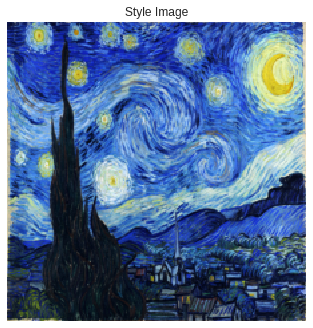

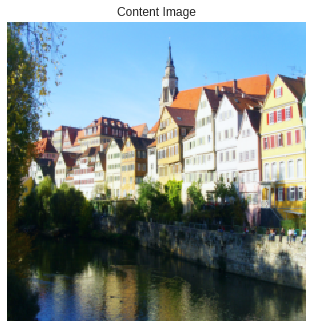

Step 0 losses:	Content 0.0006   Style 0.0091   Total 4537.8867


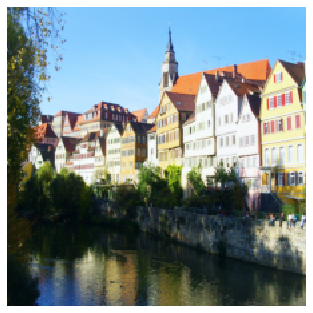

Step 250 losses:	Content 50.7286   Style 0.0001   Total 82.025
Step 500 losses:	Content 43.9612   Style 0.0001   Total 72.0206
Step 750 losses:	Content 46.361   Style 0.0001   Total 71.7508
Step 1000 losses:	Content 41.6032   Style 0.0   Total 62.1499
Step 1250 losses:	Content 54.7635   Style 0.0002   Total 150.6431
Step 1500 losses:	Content 43.409   Style 0.0   Total 64.7041
Step 1750 losses:	Content 41.0683   Style 0.0   Total 60.677
Step 2000 losses:	Content 46.7438   Style 0.0   Total 71.1848
Step 2250 losses:	Content 40.7441   Style 0.0   Total 59.2983
Step 2500 losses:	Content 39.2131   Style 0.0   Total 58.0019


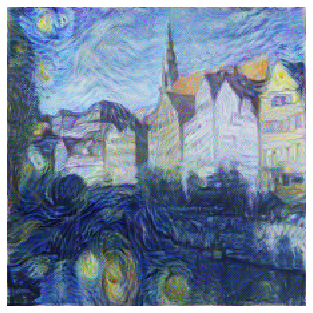

Step 2750 losses:	Content 96.6985   Style 0.001   Total 581.8556
Step 3000 losses:	Content 42.4768   Style 0.0   Total 62.2759
Step 3250 losses:	Content 39.5766   Style 0.0   Total 57.7023
Step 3500 losses:	Content 38.7794   Style 0.0   Total 56.5572
Step 3750 losses:	Content 43.6632   Style 0.0001   Total 68.772
Step 4000 losses:	Content 40.2424   Style 0.0   Total 59.8894
Step 4250 losses:	Content 43.5217   Style 0.0   Total 64.4079
Step 4500 losses:	Content 39.9938   Style 0.0   Total 58.3739
Step 4750 losses:	Content 38.8096   Style 0.0   Total 57.3125
Step 5000 losses:	Content 45.7422   Style 0.0   Total 70.016


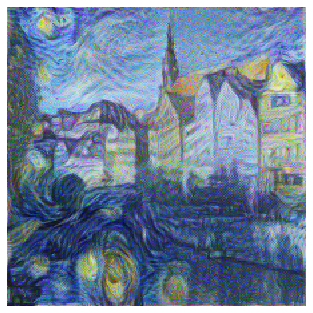

Step 5250 losses:	Content 39.1927   Style 0.0   Total 57.3896


KeyboardInterrupt: ignored

In [0]:
beta = 5e5 # Style weighting